TODO:

1. Parallelize Sim
2. Hook Sim up to a controller

In [ ]:
from typing import List, Tuple
import numpy as np
import torch

from drawing import draw_lines


def cross_product2d(a: np.ndarray, b: np.ndarray) -> np.ndarray:
  if a.shape[0] == 0 or b.shape[0] == 0:
    return np.zeros(0)
  return a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]

class Sim:
  class Data:
    def __init__(self) -> None:
      pass

    @property
    def pos(self) -> torch.Tensor:
      pass

    @property
    def theta(self) -> torch.Tensor:
      pass

    @property
    def v(self) -> torch.Tensor:
      pass

    @property
    def w(self) -> torch.Tensor:
      pass

    @property
    def rotation_matrices(self) -> torch.Tensor:
      pass
    
  def __init__(
    self,
    positions: np.ndarray,
    segments: List[Tuple[int, int, int]],  # center of mass, render point 1, render point 2
    connections: List[Tuple[int, int, int]],
    collision_points: List[Tuple[int, int]]  # segment, point
  ):
    self.origins = np.stack([positions[origin] for origin, _, __ in segments])
    self.velocities = np.zeros((len(segments), 2))
    self.angles = np.zeros(len(segments))
    self.angular_velocities = np.zeros(len(segments))
    
    connections = np.array(connections, dtype=np.long)
    self.connections = connections[:, :2]
    self.connection_points1 = positions[connections[:, 2]] - self.origins[connections[:, 0]]
    self.connection_points2 = positions[connections[:, 2]] - self.origins[connections[:, 1]]
    
    self.render_points1 = positions[[pos1 for _, pos1, __ in segments]] - self.origins
    self.render_points2 = positions[[pos2 for _, __, pos2 in segments]] - self.origins
    
    self.collision_segments = np.array([segment for segment, _ in collision_points], dtype=np.long)
    self.collision_points = positions[[point for _, point in collision_points]] - self.origins[self.collision_segments]

  def step(self):
    masses = 1
    moments_of_inertia = 0.1
    connection_restoring_force_factor = 0.05
    connection_restoring_force_limit = 0.00005
    angular_damping_factor = 0.1
    ground_friction_coefficient = 0.4

    rotation_matrices = self._rotation_matrices()
    connection_points1 = np.matmul(rotation_matrices[self.connections[:, 0]], self.connection_points1[:, :, None]).squeeze(-1)
    connection_points2 = np.matmul(rotation_matrices[self.connections[:, 1]], self.connection_points2[:, :, None]).squeeze(-1)
    connection_discrepancy = (
      (connection_points2 + self.origins[self.connections[:, 1]])
      - (connection_points1 + self.origins[self.connections[:, 0]])
    )
    # connection restoring forces
    force_vectors1 = connection_restoring_force_factor * np.linalg.norm(connection_discrepancy, axis=-1) * connection_discrepancy
    force_vectors1 = np.clip(force_vectors1, min=-connection_restoring_force_limit, max=connection_restoring_force_limit)
    force_vectors2 = -force_vectors1

    total_linear_forces = np.zeros((len(self.origins), 2))
    np.add.at(total_linear_forces, self.connections[:, 0], force_vectors1)
    np.add.at(total_linear_forces, self.connections[:, 1], force_vectors2)

    total_angular_forces = np.zeros(len(self.origins))
    np.add.at(total_angular_forces, self.connections[:, 0], cross_product2d(connection_points1, force_vectors1))
    np.add.at(total_angular_forces, self.connections[:, 1], cross_product2d(connection_points2, force_vectors2))

    # angular damping
    total_angular_forces -= angular_damping_factor * np.abs(self.angular_velocities) * self.angular_velocities

    r = np.matmul(rotation_matrices[self.collision_segments], self.collision_points[:, :, None]).squeeze(-1)
    
    # v = vo + w x r = [fx / m, fy / m] + (rx * fy - ry * fx) / I * [-ry, rx]
    # va = vo + w x r = [vox, voy] + w * [-ry, rx]
    # vay = voy + w * rx
    # vx = fx / m - (rx * fy - ry * fx) / I * ry
    # vy = fy / m + (rx * fy - ry * fx) / I * rx
    # vy = fy / m + rx^2 * fy / I
    # vy = fy * (1 / m + rx^2 / I)
    # fy = -vay / (1 / m + rx^2 / I)
    # --- # fx = min(vx * m, fy * .2)
    # vo = f / m, w = r x f / I = (rx * fy - ry * fx) / I

    
    # if fx <= 0.2 * fy:
    # -vax = fx / m - (rx * fy - ry * fx) / I * ry
    # -vay = fy / m + (rx * fy - ry * fx) / I * rx
    # 
    # (fx / m + vax) / ry = (rx * fy - ry * fx) / I
    # -(vay + fy / m) / rx = (rx * fy - ry * fx) / I
    # (fx / m + vax) * rx = -(vay + fy / m) * ry
    # fx * rx = -(vay * m + fy) * ry - vax * rx * m
    # fx * rx = -fy * ry - m * (vay * ry - vax * rx)

    # -vay = fy / m + (rx * fy * rx - ry * fx * rx) / I
    # -vay = fy / m + (rx * fy * rx - ry * (-fy * ry - m * (vay * ry - vax * rx))) / I
    # -vay = fy / m + (rx * fy * rx + fy * ry^2 + ry * m * (vay * ry - vax * rx)) / I
    # -vay = fy / m + (rx * fy * rx + fy * ry^2) / I  + ry * m * (vay * ry - vax * rx) / I
    # -vay = fy / m + fy * (rx^2 + ry^2) / I  + ry * m * (vay * ry - vax * rx) / I
    # -vay = fy * (1 / m + (rx^2 + ry^2) / I) + ry * m * (vay * ry - vax * rx) / I
    # fy = -(vay + ry * m * (vay * ry - vax * rx) / I) / (1 / m + (rx^2 + ry^2) / I)

    # if fx > 0.2 * fy:
    # fx = abs(0.2 * fy) * -sign(vax)
    # -vay = fy / m + (rx * fy - ry * fx) / I * rx
    # -vay = fy * (1 / m + rx^2 / I + rx * ry * 0.2 * sign(vax) / I)
    # fy = -vay / (1 / m + rx^2 / I + rx * ry * 0.2 * sign(vax) / I)
    distance_below_ground = np.clip(-2 - (r + self.origins[self.collision_segments])[:, 1], min=0)
    vp = np.stack((
      self.velocities[self.collision_segments, 0] - self.angular_velocities[self.collision_segments] * r[:, 1],
      self.velocities[self.collision_segments, 1] + self.angular_velocities[self.collision_segments] * r[:, 0]
    ), axis=-1)
    collision_mask = (distance_below_ground > 0) & (vp[:, 1] < 0)
    r = r[collision_mask]
    collision_segments = self.collision_segments[collision_mask]
    vp = vp[collision_mask]

    m_vay_ry_vax_rx = masses * (vp[:, 1] * r[:, 1] - vp[:, 0] * r[:, 0])
    fy = -(vp[:, 1] + r[:, 1] * m_vay_ry_vax_rx / moments_of_inertia) / (1 / masses + np.square(r).sum(-1) / moments_of_inertia)
    fx_rx = -fy * r[:, 1] - m_vay_ry_vax_rx

    fy_friction_capped = -vp[:, 1] / (1 / masses + np.square(r[:, 0]) / moments_of_inertia + vp.prod(-1) * ground_friction_coefficient * np.sign(vp[:, 0]) / moments_of_inertia)
    fx_friction_capped = -np.sign(vp[:, 0]) * ground_friction_coefficient * np.abs(fy)
    friction_capped = np.abs(fx_rx) > np.abs(r[:, 0] * ground_friction_coefficient * fy)
    # fy = -vp[:, 1] / (1 / masses + np.square(r[:, 0]) / moments_of_inertia)
    

    print('fy', fy)
    print('fyc', fy_friction_capped)
    print('fxrx', fx_rx)
    print('fxc', fx_friction_capped)
    # print(fy.shape)
    collision_forces = np.zeros((collision_segments.shape[0], 2))
    collision_forces[friction_capped, 0] = fx_friction_capped[friction_capped]
    collision_forces[friction_capped, 1] = fy_friction_capped[friction_capped]
    # print(fx_rx.shape, friction_capped.shape, r.shape)
    fx = fx_rx[~friction_capped] / r[~friction_capped, 0]
    fx[fx_rx[~friction_capped] == 0] = 0
    collision_forces[~friction_capped, 0] = fx
    collision_forces[~friction_capped, 1] = fy[~friction_capped]
    print('col', collision_forces)
    # collision_forces = np.stack((np.zeros_like(fy), fy), axis=-1)
    # ground_restoring_force = np.clip(0.001 * np.stack((np.zeros(collision_points.shape[0]), distance_below_ground), axis=-1), max=0.0001)
    # print(collision_forces)
    # collision_forces = np.clip(collision_forces, -0.005, 0.005)
    np.add.at(total_linear_forces, collision_segments, collision_forces)
    np.add.at(total_angular_forces, collision_segments, cross_product2d(r, collision_forces))
    self.origins[collision_segments, 1] += distance_below_ground[collision_mask]

    self.velocities += total_linear_forces / masses
    self.angular_velocities += total_angular_forces / moments_of_inertia
    self.origins += self.velocities
    self.angles += self.angular_velocities

  def render(self, origin: Tuple[float, float], resolution: Tuple[int, int], pixels_per_unit: float) -> np.ndarray:
    rotation_matrices = self._rotation_matrices()
    points1 = np.matmul(rotation_matrices, self.render_points1[:, :, None]).squeeze(-1) + self.origins
    points2 = np.matmul(rotation_matrices, self.render_points2[:, :, None]).squeeze(-1) + self.origins

    def cvt(points: np.ndarray):
      points = (points - origin) * pixels_per_unit
      points[:, 1] *= -1
      points = np.flip(points, axis=-1)
      points += np.array(resolution) / 2
      return points

    canvases = np.zeros((1, *resolution))
    draw_lines(canvases, cvt(np.array([[-5.0, -2.0]])), cvt(np.array([[5.0, -2.0]])), sample_count=20, width=0.1 * pixels_per_unit, width_pass_count=int(0.2 * pixels_per_unit))
    for start, end in zip(cvt(points1), cvt(points2)):
      draw_lines(canvases, start[None, :], end[None, :], sample_count=100, width=0.1 * pixels_per_unit, width_pass_count=int(0.2 * pixels_per_unit))
    return canvases[0]

  def _rotation_matrices(self) ->  np.ndarray:
    rotation_matrices = np.zeros((len(self.origins), 2, 2))
    rotation_matrices[:, 0, 0] = np.cos(self.angles)
    rotation_matrices[:, 1, 0] = np.sin(self.angles)
    rotation_matrices[:, 0, 1] = -np.sin(self.angles)
    rotation_matrices[:, 1, 1] = np.cos(self.angles)
    return rotation_matrices

    
sim = Sim(
  positions=np.array([[-2.0, 0.0], [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [2.0, 0.0]]),
  segments=[(1, 0, 2), (3, 2, 4)],
  connections=[(0, 1, 2)],
  collision_points=[(0, 0), (1, 4)]
)
print(sim.connection_points1, sim.connection_points2)

[[1. 0.]] [[-1.  0.]]


origins: [[-1.  0.]
 [ 1.  0.]]
angles: [0. 0.]
[]


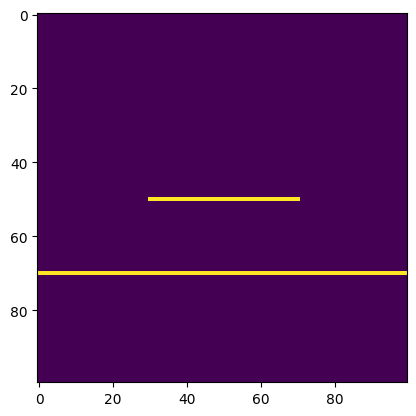

In [2]:
# sim.origins[0] = np.array([-0.9, 1.0])
import matplotlib.pyplot as plt
print('origins:', sim.origins)
print('angles:', sim.angles)

sim.step()
plt.imshow(sim.render((0, 0), (100, 100), 10))

In [39]:
sim = Sim(
  positions=np.array([[-2.0, 0.0], [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [2.0, 0.0]]),
  segments=[(1, 0, 2), (3, 2, 4)],
  connections=[(0, 1, 2)],
  collision_points=[(0, 0), (1, 4)]
)
sim.angular_velocities[0] = 0.01
sim.angular_velocities[1] = -0.01
# sim.velocities[0] = np.array([0.01, 0.01])

In [17]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

sim = Sim(
  positions=np.array([[-0.5, -1.0], [-0.5, 0.0], [-0.5, 1.0], [0.0, 1.0], [0.5, 1.0], [0.5, 0.0], [0.5, -1.0]]),
  segments=[(1, 0, 2), (3, 2, 4), (5, 4, 6)],
  connections=[(0, 1, 2), (1, 2, 4)],
  collision_points=[(0, 0), (2, 6), (1, 2), (1, 4)]
)
sim.velocities[1, 0] = 0.0001
# sim = Sim(
#   positions=np.array([[-2.0, 0.0], [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [2.0, 0.0]]),
#   segments=[(1, 0, 2), (3, 2, 4)],
#   connections=[(0, 1, 2)],
#   collision_points=[(0, 0), (1, 4)]
# )
# sim.angular_velocities[0] = 0.01
# sim.angular_velocities[1] = -0.01
# sim.velocities[0] = np.array([0.01, 0.01])

# Create a sample image (replace with your image loading)
fig, ax = plt.subplots()
im = ax.imshow(sim.render((0, 0), (500, 500), 50))
ax.axis('off')

space_pressed = False
interval_ms = 50  # Update interval in milliseconds

def on_key_press(event):
    global space_pressed
    if event.key == ' ':
        space_pressed = True

def on_key_release(event):
    global space_pressed
    if event.key == ' ':
        space_pressed = False

def update(frame):
    if space_pressed:
        # TODO: Add your image change logic here
        for _ in range(100):
          sim.velocities[:, 1] -= 0.000001
          sim.step()
        im.set_data(sim.render((0, 0), (500, 500), 50))
        # Example: im.set_data(new_image)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('key_press_event', on_key_press)
fig.canvas.mpl_connect('key_release_event', on_key_release)

ani = FuncAnimation(fig, update, interval=interval_ms, blit=False, cache_frame_data=False)

plt.show()

In [172]:
print(sim.origins)

[[nan nan]
 [nan nan]
 [nan nan]]


In [266]:
for _ in range(10):
  sim.velocities[:, 1] -= 0.0001
  print(sim.origins)
  sim.step()
plt.imshow(sim.render((0, 0), (100, 100), 10))

[[ 8.56798458 -2.67707341]
 [ 8.79065032 -3.38021969]
 [ 8.64166161 -2.49648648]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.56943433 -2.6750335 ]
 [ 8.7975686  -3.3783163 ]
 [ 8.6431478  -2.49889044]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.57104383 -2.67299891]
 [ 8.80424814 -3.37694758]
 [ 8.644713   -2.50105442]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.57285474 -2.67097041]
 [ 8.81060872 -3.37617569]
 [ 8.64639573 -2.50291546]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.57490719 -2.66895645]
 [ 8.81656976 -3.37604822]
 [ 8.64823646 -2.50441755]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.5772369  -2.66697421]
 [ 8.82205586 -3.37659239]
 [ 8.65027489 -2.50551629]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.57987257 -2.66504977]
 [ 8.82700202 -3.37781098]
 [ 8.65254729 -2.50618279]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.58283405 -2.66321727]
 [ 8.83135791 -3.37968065]
 [ 8.65508414 -2.5064063 ]]
fy []
fyc []
fxrx []
fxc []
col []
[[ 8.58613124 -2.66151697]
 [ 8.83509061 -3.38215281]
 [ 8.65790